In [2]:
pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 33.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 KB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import matplotlib.pyplot as plt
import math
import tqdm
from tqdm import tqdm
import numpy as np

import torch
import torchvision
from torch import nn
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter # Permet de générer des fichiers exploitables par TensorBoard

#**1. MLP : utilisation du GPU**

In [4]:
# Test disponibilité du GPU
if torch.cuda.is_available() :
    device = torch.device("cuda:0")
    print(" Proceseur disponible:",device,"device name :",torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Processeur disponible:",device)

# Permet de forcer l'utilisation sur CPU:
#device = torch.device("cpu")

Processeur disponible: cpu


In [5]:
# On redéfinit l'architecture de notre MLP
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.Sigmoid(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(512,128),
      nn.Sigmoid(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(128, 10)
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''       # il faut l'ajouter au moment du test si on le souhaite
    return self.layers(x)    # voir la méthode def perf_loop(dataloader, model):

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    nb_batches = len(dataloader)
    epoch_loss = 0

    # Initialize tqdm progress bar
    pbar = tqdm(total=nb_batches, desc='Training', position=0)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm progress bar with current loss
        pbar.set_postfix({'train_loss': loss.item()}, refresh=True)
        pbar.update(1)
    pbar.close()
    return epoch_loss / nb_batches


def valid_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    nb_batches = len(dataloader)
    valid_loss = 0

    # Initialize tqdm progress bar
    pbar = tqdm(total=nb_batches, desc='Validation', position=0)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            valid_loss += loss_fn(pred, y).item()
             # Update tqdm progress bar with current loss
            pbar.set_postfix({'valid_loss': valid_loss}, refresh=True)
            pbar.update(1)

    pbar.close()

    valid_loss /= nb_batches
    return valid_loss


def perf_loop(dataloader, model,device):
    Total = len(list(dataloader.dataset))
    nb_batches = len(dataloader)
    Positifs = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            prob_pred = nn.Softmax(dim=1)(pred) # pas nécessaire pour prédire le meilleur
            y_pred = torch.argmax(prob_pred,dim=1)
            #similaires = np.array(y_pred==y)
            similaires = y_pred == y
            #Positifs += np.sum(similaires)
            Positifs += torch.sum(similaires)
    return Positifs.cpu().numpy(), Total, y_pred.cpu().numpy()


def affichage(dataloader, message):
  fig1, axs1 = plt.subplots(1,6,figsize=(6,1))
  image_batch, label_batch = next(iter(dataloader))
  for i in range(6):
    image = image_batch[i].squeeze().numpy() # squeeze les dimensions de longueur 1 : ici la dimension du canal de l'image
    message += str(label_batch[i].numpy())+" "
    plt.subplot(1,6,i+1)
    plt.imshow(image, cmap="gray")
  print(message)
  plt.show()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 13794934.38it/s]


Extracting /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw/train-images-idx3-ubyte.gz to /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 429978.50it/s]


Extracting /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw/train-labels-idx1-ubyte.gz to /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3474686.74it/s]


Extracting /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 18658696.15it/s]


Extracting /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP3/MNIST/raw

Train :1 8 6 7 4 8 


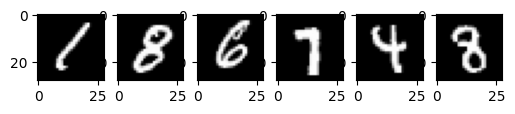

Valid :5 7 8 7 6 6 


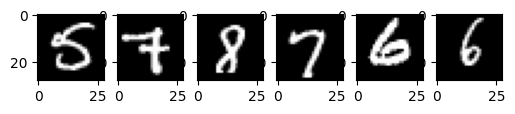

In [7]:
torch.manual_seed(42)
def load_MNIST(version="regular"):

  # On prépare le dataset MNIST choisi
  if version == 'regular':
      dataset = MNIST(os.getcwd(), train = True, download=True, transform=transforms.ToTensor())
  elif version == 'fashion':
      dataset = FashionMNIST(os.getcwd(), train = True, download=True, transform=transforms.ToTensor())
  return dataset

dataset = load_MNIST(version="regular")
# Définition des paramètres d'apprentissage du réseau (batch_size, epochs, learning_rate, optimiseur): utiliser ceux qui ont obtenu les meilleurs résultats lors du TP précédent
dim = 28 * 28  # dimension des images MNIST
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
batch_size = 64 #= 128
epochs = 20
learning_rate = 1e-2 #= 1e-3
OPTIM = "ADAM" # "SGD" "ADAM"
Model_name = "Mon_meilleur_MLP.pt"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
data = [x for x in dataset]
train_dataset = data[:N_train]
valid_dataset = data[N_train:N_train+N_valid]
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

affichage(trainloader,"Train :")
affichage(validloader,"Valid :")

 10%|█         | 2/20 [00:05<00:52,  2.94s/it]

best validation loss : 0.098020688868425


 15%|█▌        | 3/20 [00:08<00:49,  2.93s/it]

best validation loss : 0.09216418859370529


 45%|████▌     | 9/20 [00:26<00:33,  3.07s/it]

best validation loss : 0.07964555266501501


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]

Apprentisage terminé.



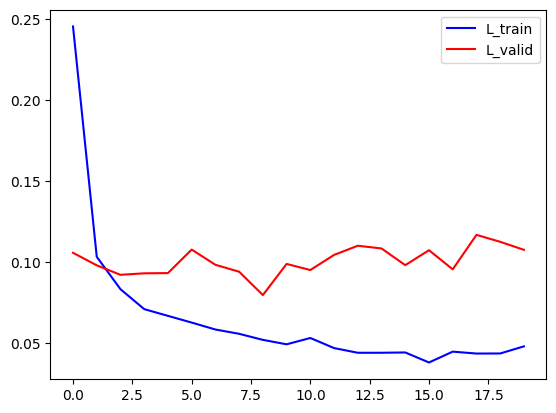

In [8]:
my_MLP = MLP(input_features = dim).to(device)
my_loss = nn.CrossEntropyLoss()
if OPTIM == "SGD":
    my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=learning_rate)
elif OPTIM == "ADAM":
    my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=learning_rate)
else:
    print("Optimiseur inconnu !!!!")

############      BOUCLES D'APPRENTISSAGE     ###########
train_loss = []
valid_loss = []
for t in tqdm(range(epochs)):
    train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer, device))
    # on test à chaque itération
    valid_loss.append(valid_loop(validloader, my_MLP, my_loss, device))
    # mettre ici le Early Stopping
    if t == 0:
        best_valid_loss = valid_loss[-1]
    else:
        if valid_loss[-1] < best_valid_loss:
            best_valid_loss = valid_loss[-1]
            print(f"best validation loss : {best_valid_loss}")
            # on mémorise ce modèle
            best_iter = t
            torch.save(my_MLP.state_dict(), Model_name)

print('Apprentisage terminé.\n')

# visu des loss train et test
plt.figure()
plt.plot(train_loss,"b",label="L_train")
plt.plot(valid_loss,"r",label="L_valid")
plt.legend()

Test :7 2 1 0 4 1 


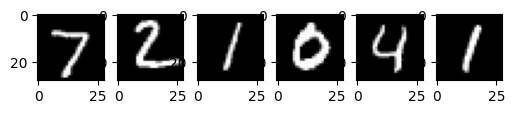

Taux de reco en Test: 9770 / 10000 = 97.7 % de réussite
Meilleure époque : 9
Nombre de paramètres libres: 468874


In [9]:
############## Vérification des performances sur un ensemble de test séparé ################
test_dataset = MNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())
N_test = len(test_dataset)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=N_test, shuffle=False, num_workers=1)
affichage(testloader,"Test :")

my_best_MLP = MLP(input_features = dim).to(device)
my_best_MLP.load_state_dict(torch.load(Model_name))
Positifs, Total, y_pred = perf_loop(testloader, my_best_MLP, device)
print("Taux de reco en Test:",Positifs,"/", Total, "=", (Positifs/Total)*100, "% de réussite")
print("Meilleure époque :",best_iter+1)

nb_train_param = count_parameters(my_best_MLP)
print("Nombre de paramètres libres:",nb_train_param)

#**2. CNN**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # premier bloc conv ReLU Pooling à 16 canaux
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # second bloc conv ReLU Pooling à 32 canaux sur carte de taille 7 x 7 car 2 MaxPooling
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        # fully connected layer, output 10 classes
        self.last_layer = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        output = self.last_layer(x)
        return output

Train :0 2 1 5 7 9 


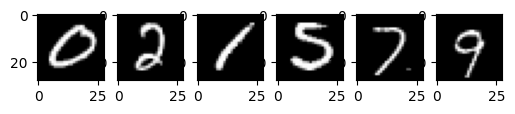

Valid :6 0 1 1 4 4 


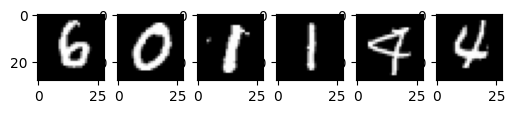

In [ ]:
dataset = load_MNIST(version="regular") # changer pour la dernière partie du TP
# Définition des paramètres d'apprentissage du réseau (batch_size, epochs, learning_rate, optimiseur): utiliser ceux qui ont obtenu les meilleurs résultats lors du TP précédent
dim = 28 * 28  # dimension des images MNIST
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
batch_size = 64 #= 128
epochs = 20
learning_rate = 1e-2 #= 1e-3
OPTIM = "ADAM" # "SGD" "ADAM"
Model_name = "Mon_meilleur_MLP.pt"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
data = [x for x in dataset]
train_dataset = data[:N_train]
valid_dataset = data[N_train:N_train+N_valid]
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

affichage(trainloader,"Train :")
affichage(validloader,"Valid :")

In [ ]:
# Initialisation du writer de TensorBoard
writer = SummaryWriter()

#################  Instanciation du CNN #################
my_CNN = CNN().to(device)

batch_size = 64 #= 128
epochs = 20
learning_rate = 1e-2 #= 1e-3
OPTIM = "ADAM" # "SGD" "ADAM"
Model_name = "Mon_meilleur_CNN.pt"

my_loss = nn.CrossEntropyLoss()
if OPTIM == "SGD":
    my_optimizer = torch.optim.SGD(my_CNN.parameters(), lr=learning_rate)
elif OPTIM == "ADAM":
    my_optimizer = torch.optim.Adam(my_CNN.parameters(), lr=learning_rate)
else:
    print("Optimiseur inconnu !!!!")

############      BOUCLES D'APPRENTISSAGE     ###########
for t in tqdm(range(epochs)):
    train_epoch_loss = train_loop(trainloader, my_CNN, my_loss, my_optimizer,device)
    # On ajoute la loss moyenne d'entrainement de l'epoch aux logs Tensorboard:
    writer.add_scalar('Loss/train', train_epoch_loss, t)

    # on test à chaque itération
    valid_epoch_loss = valid_loop(validloader, my_CNN, my_loss,device)
    # On ajoute la loss moyenne de validation de l'epoch aux logs Tensorboard:
    writer.add_scalar('Loss/valid', valid_epoch_loss, t)

    if t == 0:
        best_valid_loss = valid_epoch_loss
    else:
        if valid_epoch_loss < best_valid_loss:
            best_valid_loss = valid_epoch_loss
            print(f"best validation loss : {best_valid_loss}")

            # on mémorise ce modèle
            best_iter = t

            torch.save(my_CNN.state_dict(), Model_name)

print('Apprentisage terminé.\n')

100%|██████████| 20/20 [02:36<00:00,  7.84s/it]

Apprentisage terminé.



In [ ]:
############## on teste maintenaant les performances ################
if dataset == 'regular':
    test_dataset = MNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())
elif dataset == 'fashion':
    test_dataset = FashionMNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())

N_test = len(test_dataset)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=N_test, shuffle=False, num_workers=1)

Positifs, Total, y_pred = perf_loop(testloader, my_CNN,device)
print("Taux de reco en Test:",Positifs,"/", Total)
print("Meilleure époque :",best_iter)

nb_train_param = count_parameters(my_CNN)
print("Nombre de paramètres libres:",nb_train_param)

# On ajoute à Tensorboard les performances obtenus pour la combinaison actuelle d'hyperparamètres:
writer.add_hparams({'lr': learning_rate, 'bsize': batch_size}, {'hparam/accuracy': Positifs/Total, 'hparam/loss': best_valid_loss})
writer.close()

Taux de reco en Test: 9835 / 10000
Meilleure époque : 8
Nombre de paramètres libres: 20490


Réitérer cette partie avec la version FASHION de MNIST, en faisant varier l'architecture (nombre de couches, nombre de noyaux de convolution par couche, taille des noyaux, etc).

In [ ]:
# Éléments de visualisation supplémentaire avec Tensoboard
my_CNN.to('cpu')
images, labels = next(iter(trainloader))
writer.add_graph(my_CNN, images)
# on ajoute le graph de l'architecture du modèle à Tensorboard

grid = torchvision.utils.make_grid(images)
# On ajoute un échantillon des images du dataset à Tensorboard:
writer.add_image('images', grid, 0)

# Avec Tensorboard, il est également possible de visualiser des projection de données
# Nous allons ici projeter 200 images aléatoires du jeu de test
# Pour cela, nous allons récupérer pour chacune de ces images, l'activation obtenue au niveau de l'avant dernière couche du modèle

# A décommenter si vous utilisez le code dans Colab:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

if MNIST == 'fashion':
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
else:
  classes = list(range(10))

def get_activation_sample(dataloader, model, device, nb_samples=200):
  with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        layer_activation = model.conv1(X.float())
        layer_activation = model.conv2(layer_activation)
        # Plutôt que d'utiliser la fonction forward appelée implicitement lorsqu'on fait "model(X)",
        # on passe manuellement dans chaque couche et on s'arrête à l'avant-dernière couche.

  return layer_activation[:nb_samples], y[:nb_samples], X[:nb_samples]

samples, sample_labels, sample_images = get_activation_sample(testloader, my_CNN, 'cuda:0')
sample_labels = [classes[lab] for lab in sample_labels]
writer.add_embedding(samples, metadata=sample_labels, label_img=sample_images)